## Figure 2. Comparing RD, FD and BP



Imports

In [10]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns

from lib.lif import LIF, ParamsLIF
from lib.causal import causaleffect, causaleffect_linear

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## A. Dependence on $p$ and $c$

In [11]:
nsims = 500
cvals = np.array([0.01, 0.25, 0.5, 0.75, 0.99])
pvals = np.linspace(0.01, 1, 10)

tau_s = 0.020
dt = 0.001

alpha1 = -30
alpha2 = 20
x = 3

params = ParamsLIF()
params_orig = ParamsLIF()
lif = LIF(params)

t_filter = np.linspace(0, 0.150, 150)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

#c (correlation between noise inputs)
beta_rd_c = np.zeros((len(cvals), nsims, len(pvals), params.n))
beta_fd_c = np.zeros((len(cvals), nsims, params.n))
beta_bp_c = np.zeros((len(cvals), nsims, params.n))

beta_rd_c_linear = np.zeros((len(cvals), nsims, len(pvals), params.n))
beta_fd_c_linear = np.zeros((len(cvals), nsims, params.n))

m_beta_bp_c = np.zeros(params.n)
m_beta_rd_c = np.zeros((len(cvals), params.n))
se_beta_fd_c = np.zeros((len(cvals), params.n))
m_beta_rd_c = np.zeros((len(cvals), params.n))
se_beta_fd_c = np.zeros((len(cvals), params.n))

m_beta_rd_c_linear = np.zeros((len(cvals), params.n))
se_beta_fd_c_linear = np.zeros((len(cvals), params.n))
m_beta_rd_c_linear = np.zeros((len(cvals), params.n))
se_beta_fd_c_linear = np.zeros((len(cvals), params.n))

In [12]:
for i,c in enumerate(cvals):
    print("Running %d simulations with c=%s"%(nsims, c))
    params.c = c
    lif.setup(params)
    for j in range(nsims):
        (v, h, _, _) = lif.simulate()
        s1 = np.convolve(h[0,:], exp_filter)[0:h.shape[1]]
        s2 = np.convolve(h[1,:], exp_filter)[0:h.shape[1]]
        cost_s = (alpha1*s1 + alpha2*s2 - x**2)**2
        for k,p in enumerate(pvals):
            beta_rd_c[i,j,k,:] = causaleffect(v, cost_s, p, params)
            beta_rd_c_linear[i,j,k,:] = causaleffect_linear(v, cost_s, p, params)
        beta_fd_c[i,j,:] = causaleffect(v, cost_s, 1, params)
        beta_fd_c_linear[i,j,:] = causaleffect_linear(v, cost_s, 1, params)

Running 500 simulations with c=0.01
Running 500 simulations with c=0.25
Running 500 simulations with c=0.5
Running 500 simulations with c=0.75
Running 500 simulations with c=0.99


In [13]:
m_beta_rd_c = np.mean(beta_rd_c, 1)
se_beta_rd_c = np.std(beta_rd_c, 1)

m_beta_fd_c = np.mean(beta_fd_c, 1)
se_beta_fd_c = np.std(beta_fd_c, 1)

m_beta_rd_c_linear = np.mean(beta_rd_c_linear, 1)
se_beta_rd_c_linear = np.std(beta_rd_c_linear, 1)

m_beta_fd_c_linear = np.mean(beta_fd_c_linear, 1)
se_beta_fd_c_linear = np.std(beta_fd_c_linear, 1)

m_beta_bp_c[0] = (alpha1**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s2)*ds-2*alpha1*(x**2)*ds
m_beta_bp_c[1] = (alpha2**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s1)*ds-2*alpha2*(x**2)*ds

Use seaborn for plotting

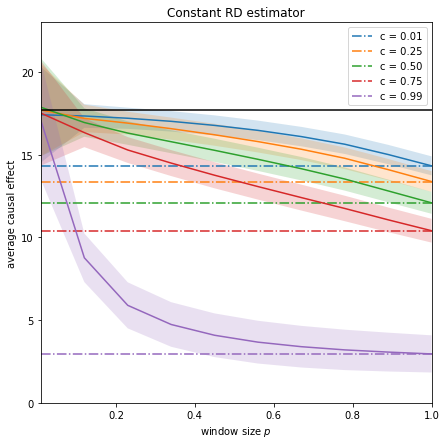

In [14]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
for i in range(len(cvals)):
    sns.tsplot(data=-beta_rd_c[i,:,:,u], ax = ax, ci="sd", time=pvals, color='C%d'%i)
    ax.plot(pvals, -m_beta_rd_c[i,-1,u]*ones(pvals.shape), '-.', color='C%d'%i)
ax.set_xlabel('window size $p$');
ax.set_ylabel('average causal effect');
ax.set_title('Constant RD estimator');
ax.plot(pvals, -m_beta_bp_c[u]*ones(pvals.shape), color=(0,0,0));
ax.set_ylim([0, 23])
ax.legend(["c = %.2f"%i for i in cvals]);
plt.savefig('./fig_2a.pdf')

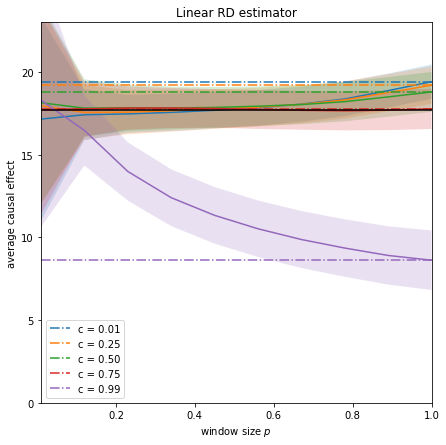

In [15]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
for i in range(len(cvals)):
    sns.tsplot(data=-beta_rd_c_linear[i,:,:,u], ax = ax, ci="sd", time=pvals, color='C%d'%i)
    ax.plot(pvals, -m_beta_rd_c_linear[i,-1,u]*ones(pvals.shape), '-.', color='C%d'%i)
ax.set_xlabel('window size $p$');
ax.set_ylabel('average causal effect');
ax.set_title('Linear RD estimator');
ax.plot(pvals, -m_beta_bp_c[u]*ones(pvals.shape), color=(0,0,0));
ax.set_ylim([0, 23])
ax.legend(["c = %.2f"%i for i in cvals]);
plt.savefig('./fig_2a_linear.pdf')

## B. Histogram over range of weights

In [4]:
N = 20
c = 0.99
p = 0.03
fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_default_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

In [5]:
beta_rd_w = np.zeros((N, N, nsims, params.n))
beta_fd_w = np.zeros((N, N, nsims, params.n))
m_beta_rd_w = np.zeros((N, N, params.n))
m_beta_fd_w = np.zeros((N, N, params.n))
m_beta_bp_w = np.zeros((N, N, params.n))

In [59]:
for i,w1 in enumerate(wvals):
    print("Estimating betas for W0 = %d"%w1)
    for j,w2 in enumerate(wvals):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost_s = (alpha1*s1 + alpha2*s2 - x**2)**2
            beta_rd_w[i,j,k,:] = causaleffect(vs[i,j,k,:,:], cost_s, p, params)
            beta_fd_w[i,j,k,:] = causaleffect(vs[i,j,k,:,:], cost_s, 1, params)
        m_beta_bp_w[i,j,0] = (alpha1**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s2)*ds-2*alpha1*(x**2)*ds
        m_beta_bp_w[i,j,1] = (alpha2**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s1)*ds-2*alpha2*(x**2)*ds

Estimating betas for W0 = 1
Estimating betas for W0 = 2
Estimating betas for W0 = 3
Estimating betas for W0 = 4
Estimating betas for W0 = 5
Estimating betas for W0 = 6
Estimating betas for W0 = 7
Estimating betas for W0 = 8
Estimating betas for W0 = 9
Estimating betas for W0 = 10
Estimating betas for W0 = 11
Estimating betas for W0 = 12
Estimating betas for W0 = 13
Estimating betas for W0 = 14
Estimating betas for W0 = 15
Estimating betas for W0 = 16
Estimating betas for W0 = 17
Estimating betas for W0 = 18
Estimating betas for W0 = 19
Estimating betas for W0 = 20


In [60]:
m_beta_rd_w = np.mean(beta_rd_w, 2)
se_beta_rd_w = np.std(beta_rd_w, 2)
m_beta_fd_w = np.mean(beta_fd_w, 2)
se_beta_fd_w = np.std(beta_fd_w, 2)

In [61]:
d_fdbp = np.sqrt((m_beta_fd_w[:,:,0]-m_beta_bp_w[:,:,0])**2 + (m_beta_fd_w[:,:,1]-m_beta_bp_w[:,:,1])**2).reshape((-1,1))
d_rdbp = np.sqrt((m_beta_rd_w[:,:,0]-m_beta_bp_w[:,:,0])**2 + (m_beta_rd_w[:,:,1]-m_beta_bp_w[:,:,1])**2).reshape((-1,1))

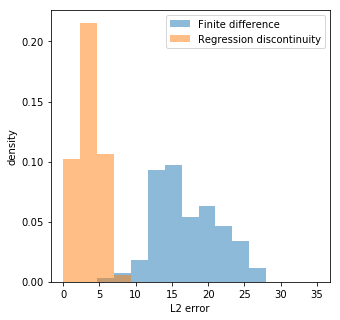

In [78]:
plt.rc('text', usetex=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5));
ax1.hist(d_fdbp, 15, normed=1, range=(0, 35), alpha=0.5);
ax1.hist(d_rdbp, 15, normed=1, range=(0, 35), alpha=0.5);
ax1.set_xlabel('L2 error')
ax1.set_ylabel('density')
ax1.legend(['Finite difference', 'Regression discontinuity']);
plt.savefig('./fig_2b.pdf')

## C. Heatmaps of cost landscape and gradient estimates

The 'banana' cost function with RD (compared with numerical gradient), and FD (compard with numerical cost gradient).

Possibly also BP (compared with numerical gradient)

In [245]:
nsims = 100
wmax = 20

cost2 = np.zeros((N,N))
cost2_tmp = np.zeros((nsims,hs.shape[4]))

beta_fd_w2 = np.zeros((nsims, params.n))
beta_rd_w2 = np.zeros((nsims, params.n))
m_beta_fd_w2 = np.zeros((N, N, params.n))
m_beta_rd_w2 = np.zeros((N, N, params.n))

B1 = 2
B2 = 7
x = .05
y = 0.15
z = -0.2

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost2_tmp[k,:] = (B1*s1-x)**2 + (z+B2*s2 - B2*(2*B1*s1-y)**2)**2
            beta_fd_w2[k,:] = causaleffect(vs[i,j,k,:,:], cost2_tmp[k,:], 1, params)
            beta_rd_w2[k,:] = causaleffect(vs[i,j,k,:,:], cost2_tmp[k,:], p, params)
        cost2[i,j] = np.mean(cost2_tmp)
        m_beta_rd_w2[i,j,:] = np.mean(beta_rd_w2, 0)
        m_beta_fd_w2[i,j,:] = np.mean(beta_fd_w2, 0)

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


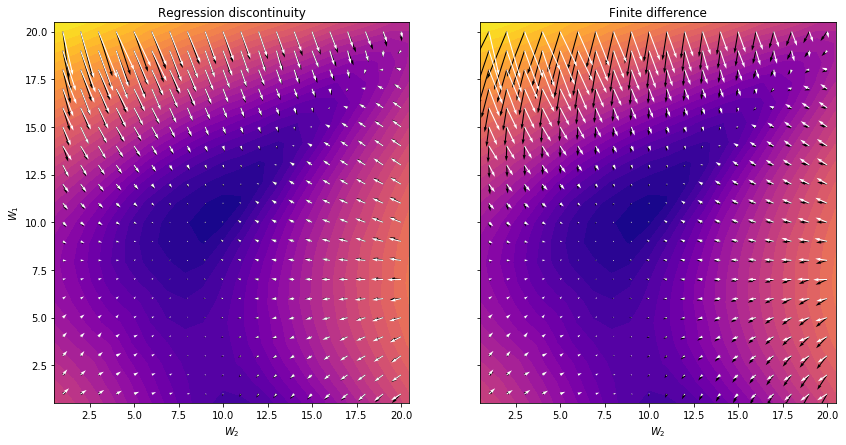

In [246]:
grad = np.gradient(cost2)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7), sharey = True)
a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
ax1.quiver(X, Y, -m_beta_rd_w2[:,:,1], -m_beta_rd_w2[:,:,0], color=(0, 0, 0))
ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
#fig.colorbar(a);
ax1.set_title("Regression discontinuity")
ax1.set_xlabel('$W_2$')
ax1.set_ylabel('$W_1$')

#fig, (ax1) = plt.subplots(1,1,figsize=(8,8))
a=ax2.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
Q = ax2.quiver(X, Y, -m_beta_fd_w2[:,:,1], -m_beta_fd_w2[:,:,0], color=(0, 0, 0))
ax2.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
#fig.colorbar(a);
ax2.set_title("Finite difference")
ax2.set_xlabel('$W_2$')
#ax2.set_ylabel('$W_1$')
plt.savefig('./fig_2c.pdf')